In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotly import graph_objs as go
import regex as re
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
nltk.download('stopwords')
stopwords = set((stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Twitter_Data1.csv')
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,said the action was not directed against any c...,1.0
4,congratulations our shri narwndrea modi and dr...,0.0


In [4]:
len(df)

93183

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


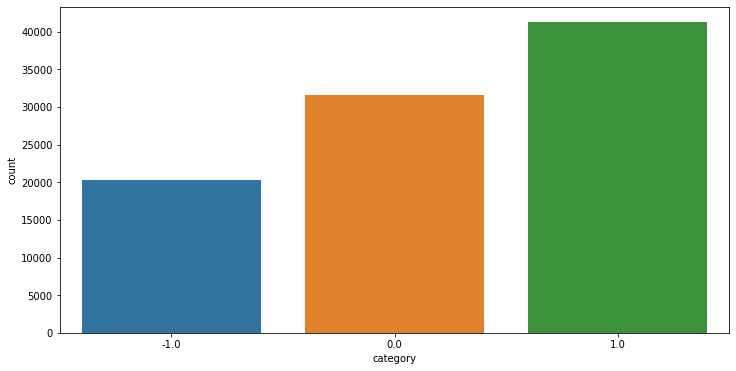

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(x='category',data=df)

In [7]:
temp = df.groupby('category').count()['clean_text'].reset_index().sort_values(by='clean_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,category,clean_text
2,1.000000,41257
1,0.000000,31587
0,-1.000000,20329


In [8]:
fig = go.Figure(go.Funnelarea(
    text =temp.category,
    values = temp.clean_text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
))
fig.show()

In [9]:
def to_str(word):
  return str(word)
def to_lower(word): 
     result = word.lower() 
     return result
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def remove_mentions(word):
    return re.sub(r"@\S+", "", word)

In [10]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = re.sub('[^A-Za-z]+', ' ', word)
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')

def remove_stopwords(word):
    return ' '.join(i for i in word.split() if i not in stopwords)


In [11]:
def clean_up_pipeline(sentence):
    cleaning_data = [ to_str, remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace,
                     ]
    for func in cleaning_data:
        
        sentence = func(sentence)
    return sentence

In [12]:
df.dropna(inplace=True)
df['clean_text'] = df['clean_text'].apply(clean_up_pipeline)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.clean_text,df.category,test_size = 0.2)

In [14]:
X_train = X_train.apply(clean_up_pipeline)

In [15]:
nltk.download('punkt')
X_train = X_train.apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text])
X_train = X_train.apply(lambda text: stem_words(text))

In [17]:
bow=CountVectorizer( min_df=2, max_features=1002)
bow.fit(X_train)
bow_df=bow.transform(X_train).toarray()

In [18]:
RF = RandomForestClassifier(n_estimators=27)
RF.fit(bow_df, np.array(y_train))

RandomForestClassifier(n_estimators=27)

In [19]:
RF.max_depth

In [20]:
y_train_pred = RF.predict(bow_df)
cf_matrix =confusion_matrix(y_train,y_train_pred)

In [21]:
cf_matrix

array([[16165,    53,    24],
       [   10, 25272,    17],
       [    7,   131, 32859]])

In [22]:
print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_train_pred, average='micro')))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_train_pred, average='micro')))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_train,y_train_pred, average='micro')))

Precision: 99.68%
Recall: 99.68%
F1 Score: 99.68%


In [23]:
y_test_pred = RF.predict(bow.transform(X_test).toarray())
cf_test_matrix =confusion_matrix(y_test,y_test_pred)
cf_test_matrix


array([[1948, 1390,  749],
       [  82, 5943,  263],
       [ 425, 1935, 5900]])

In [24]:
y_test_pred

array([0., 0., 1., ..., 0., 1., 0.])

In [25]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_test_pred, average='weighted')))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_test_pred, average='weighted')))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test,y_test_pred, average='weighted')))
RF.score(bow.transform(X_test).toarray(), y_test)

Precision: 76.88%
Recall: 74.01%
F1 Score: 73.32%


0.7400590287094178

In [26]:
data_dmatrix = xgb.DMatrix(data=bow_df,label=y_train)
xgb_model = xgb.XGBClassifier()
xgb_model.fit(bow_df, np.array(y_train))
xgb_model.score(bow.transform(X_test).toarray(), y_test)

0.6803863697343708

In [27]:
y_test_pred = xgb_model.predict(bow.transform(X_test).toarray())
cf_test_matrix =confusion_matrix(y_test,y_test_pred)
cf_test_matrix

array([[1181, 1929,  977],
       [  24, 5935,  329],
       [ 194, 2503, 5563]])

xgb_model.get_params()

In [28]:
naive_bayes = GaussianNB()
naive_bayes.fit(bow_df, np.array(y_train))
naive_bayes.score(bow.transform(X_test).toarray(), y_test)

0.6541990877381272

In [29]:
knn = KNeighborsClassifier()
knn.fit(bow_df,np.array(y_train))
knn.score(bow.transform(X_test).toarray(), y_test)

0.44158840890796885

In [30]:
dt = DecisionTreeClassifier()
dt.fit(bow_df,np.array(y_train))
dt.score(bow.transform(X_test).toarray(), y_test)

0.710008049369466

In [31]:
xgb_new_model = xgb.XGBClassifier()
xgb_param = {
    'n_estimators':[20, 25, 30, 35, 50],
    'subsamples':[0.5, 0.8, 1],
    'max_depth': [1, 3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.3]
}

In [32]:
class ARMClassifier:
  def __init__(self, models_with_accuracy):
    self.models_with_accuracy = models_with_accuracy
    self.positive_count = 0
    self.neutral_count = 0
    self.negative_count = 0
    self.positive_probability = 0
    self.negative_probability = 0
    self.neutral_probability = 0
    self.total_accuracy = 0
    self.weight = {}
    self.models = []
    for i in self.models_with_accuracy:
      self.models.append(i)
      self.total_accuracy += self.models_with_accuracy[i]
    for i in self.models_with_accuracy:
      self.weight[i] = self.models_with_accuracy[i]/self.total_accuracy

  def sentiment_score(self, tweet):
    tweet = [tweet]
    
    self.positive_count = 0
    self.neutral_count = 0
    self.negative_count = 0
    self.positive_probability = 0
    self.negative_probability = 0
    self.neutral_probability = 0
    for i in self.models:
      pred = i.predict(tweet)
      if pred[0] == -1:
        self.negative_count += 1
      elif pred[0] == 0:
        self.neutral_count += 1
      else:
        self.positive_count += 1
    
    total = self.positive_count + self.negative_count + self.neutral_count

    self.positive_probability = self.positive_count/total
    self.negative_probability = self.negative_count/total
    self.neutral_probability = self.neutral_count/total
    positive_score, neutral_score, negative_score  = 0, 0, 0
    
    for model in self.models:
      positive_score += self.weight[model] * self.positive_probability
      neutral_score += self.weight[model] * self.neutral_probability
      negative_score += self.weight[model] * self.negative_probability

    return [positive_score, neutral_score, negative_score]


  def predict(self, tweets):
    output = [0] * len(tweets)
    
    for tweet_no in range(len(tweets)):
      positive_score, neutral_score, negative_score = self.sentiment_score(tweets[tweet_no])
      
      if positive_score > negative_score and positive_score > neutral_score:
        output[tweet_no] = 1
      elif negative_score > positive_score and negative_score > neutral_score:
        output[tweet_no] = -1
      elif  neutral_score > positive_score and neutral_score > negative_score:
        
        output[tweet_no] = 0
      else:
        if positive_score == negative_score:
          if self.positive_count > self.negative_count:
            output[tweet_no] = 1
          else:
            output[tweet_no] = -1
        elif positive_score == neutral_score:
          if self.positive_count > self.neutral_count:
            output[tweet_no] = 1
          else:
            output[tweet_no] = 0
        elif neutral_score == negative_score:
          if self.neutral_count > self.negative_count:
            output[tweet_no] = 0
          else:
            output[tweet_no] = -1
        else:
          if self.positive_count > self.negative_count and self.positive_count > self.neutral_count:
            output[tweet_no] = 1
          elif self.neutral_count > self.negative_count and self.neutral_count > self.positive_count:
            output[tweet_no] = 0
          else:
            output[tweet_no] = -1
          
    return output

  

In [33]:
models = [RF ,xgb_model, naive_bayes, dt]
models_with_accuracy = {}
for model in models:
  models_with_accuracy[model] = model.score(bow.transform(X_test).toarray(), y_test)

In [34]:
arm = ARMClassifier(models_with_accuracy)

In [35]:
arm.weight

{RandomForestClassifier(n_estimators=27): 0.2657635088260233,
 XGBClassifier(objective='multi:softprob'): 0.24433438680336084,
 GaussianNB(): 0.23493023972866722,
 DecisionTreeClassifier(): 0.25497186464194865}

In [36]:
for model in models:
  print(f'{model} : {model.score(bow.transform(X_test).toarray(), y_test)}')

RandomForestClassifier(n_estimators=27) : 0.7400590287094178
XGBClassifier(objective='multi:softprob') : 0.6803863697343708
GaussianNB() : 0.6541990877381272
DecisionTreeClassifier() : 0.710008049369466


In [37]:
y_arm_pred = arm.predict(bow.transform(X_test).toarray())

In [38]:
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test,y_arm_pred, average='micro')))

F1 Score: 74.35%


In [39]:
cf_test_matrix =confusion_matrix(y_test,y_arm_pred)
cf_test_matrix

array([[2045, 1464,  578],
       [  67, 6123,   98],
       [ 491, 2082, 5687]])